In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skewnormt

In [2]:
"""Constants"""
scale = 1e-6 # the time and distance were given in microseconds
mobility = 1.033148
L = 950e-6 # length of the whole semiconductor 
L1 = 225e-6 # distance from pulse injection to first contact (where the collected voltage gets collected)
L2 = 300e-6
L3 = 375e-6
L4 = 450e-6
colours = ['#b3b3ff', '#9999ff', '#8080ff', '#6666ff', '#3333ff', '#0000ff', '#0000e6', '#0000cc', '#0000b3', '#000099', '#000080', '#000066', '#00004d', '#000033', '#00001a', '#000000' ]

### Session 1:

**3a)**


AIM: find the drift velocity and mobility of the electrons?


The data from the oscilloscope looks like:
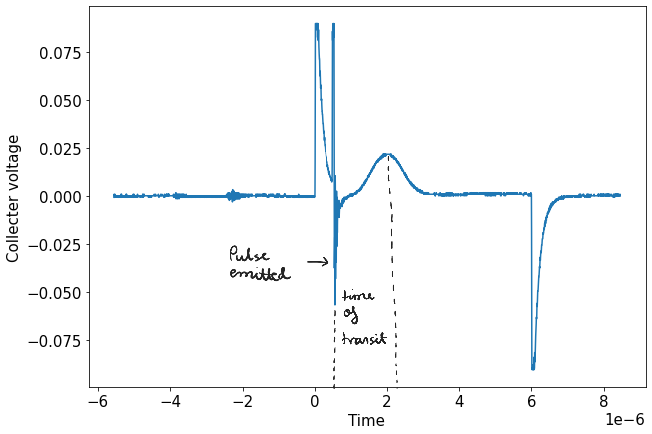

The data from the Experimental setup looked like:
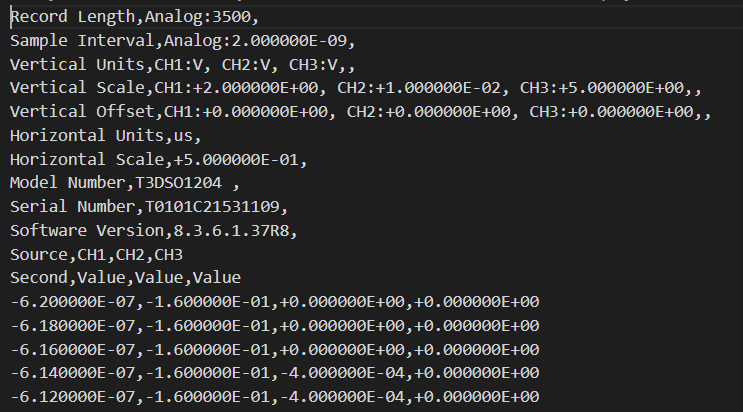

where:
- CH1 = field voltage
- CH2 = collector voltage
- CH3 = injector voltage

5.58e-07


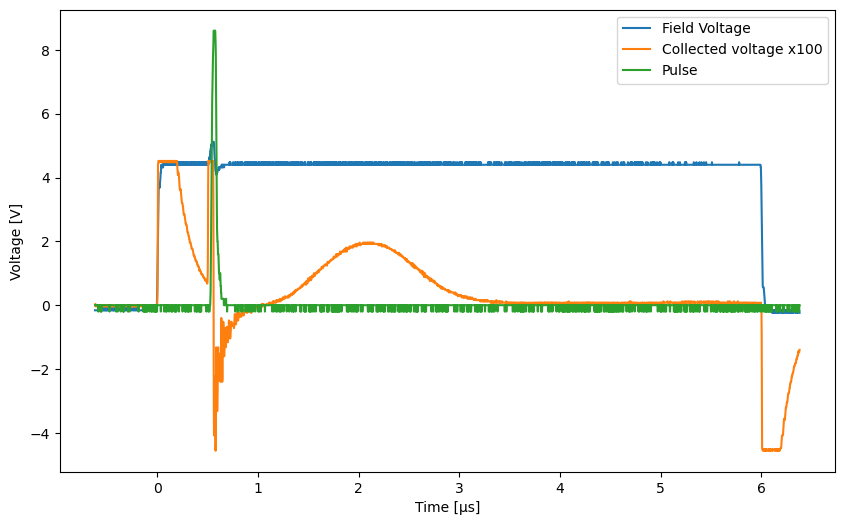

In [3]:
"""test plot of raw data"""
trial = 9

raw_data = pd.read_csv(f"./data/SDS{trial:05}.csv",
                       skiprows=12,
                       names = ("time", "v_fld", "v_coll", "v_emit"))
                      

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(raw_data["time"]/scale, raw_data["v_fld"], label='Field Voltage')
ax.plot(raw_data["time"]/scale, raw_data["v_coll"]*100, label='Collected voltage x100')
ax.plot(raw_data["time"]/scale, raw_data["v_emit"], label='Pulse')

ax.set_xlabel('Time [µs]')
ax.set_ylabel('Voltage [V]')
ax.legend()

# find when the pulse was emitted
print(raw_data['time'][raw_data['v_emit'].idxmax()])

In [4]:
"""List of functions"""
def emission_plots(data):
    peaks, properties = find_peaks(data['v_emitted'], width=20, height=3, prominence = 1)
    ax.plot(data['time'], data['v_emitted'] , color =(0,1-i*0.05,1-i*0.05))
    ax.plot(data.loc[peaks,"time"],properties["peak_heights"], "x")

def straight_line(x,m,c):
    return m*x + c

def skewed_gaussian(x, a, mu, sigma, alpha):
    # a = skewness
    # mu = mean
    #sigma = standard deviation
    # alpha = a constant offset <- idk actually what this is
    return a * skewnorm.pdf(x, alpha, loc=mu, scale=sigma)

# output time and uncertainty in time from full width at half the maximum of a peak
def get_emission_time(df):
    #max
    #max/2
    #time values at max/2
    # t = mid point, unc_t = t2-t1
    
    delta = 1.0
    halfmax = df["v_emitted"].max()/2
    data = df.loc[df["v_emitted"].between(halfmax-delta,halfmax+delta),:]
    
    t = data["time"].mean()
    t_unc = data.loc[data["time"].gt(t),"time"].mean()-data.loc[df["time"].lt(t),"time"].mean()
    return (t,t_unc)

def get_fwhm(x_data, y_data):

    df = pd.DataFrame({'x': x_data, 'y': y_data})
    max_index = df['y'].idxmax()
    y_max = df['y'][max_index]
    fwhm = max(df.loc[df['y'] > y_max/2 , 'x']) - min(df.loc[df['y'] > y_max/2 , 'x'])
    return fwhm


# function that gets transit time from data frame
def get_transit_time(data, min_time, max_time):
    
    #STEP 1: find when the pulse was emitted 
    #peaks, properties = find_peaks(data['v_emitted'], width=20, height=3, prominence = 1)
    #t_emitted = data.loc[peaks,"time"] # this is the time the pulse is emitted at
    t_emitted = get_emission_time(data) # list of emission time and its unc
        
    #STEP 2: find the time when the pulse arrives 
    curve_df = data.loc[data["time"].between(min_time, max_time),:] # relevant data, we only want the curvy bit of v_collected
    
    p0 = [max(curve_df['v_collected']), np.mean(curve_df['time']), np.std(curve_df['time']), 0]
    popt, pcov = curve_fit(skewed_gaussian, curve_df['time'], curve_df['v_collected'], p0)
    
    skewness = (popt[0], np.sqrt(pcov[0,0]))
    
    curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))   
    # time that pulse arrives is the time at peak of curve_df.
    # peak of curve_df happens at peak of fit_vals

    t_arrived = curve_df.at[curve_df["fit_vals"].idxmax(),'time']
    
    # finding the uncertainty in arrival time <-- note this is not the same as how well the skewed Gaussian fit! 
    # do not use regression analysis!
    # Regression analysis: t_arr_err = np.sqrt(pcov[2,2])    
    # use full width half maxima
    t_arr_err = get_fwhm(curve_df['time'], curve_df['fit_vals'])

    #graph plotting
    plt.plot(curve_df['time'], curve_df["fit_vals"], 'r-')
    
    #STEP 3: 
    t_transit = t_arrived - t_emitted[0]
    t_transit_err = np.sqrt(t_emitted[1]**2 + t_arr_err**2)
    
    return (t_transit, t_transit_err, skewness)

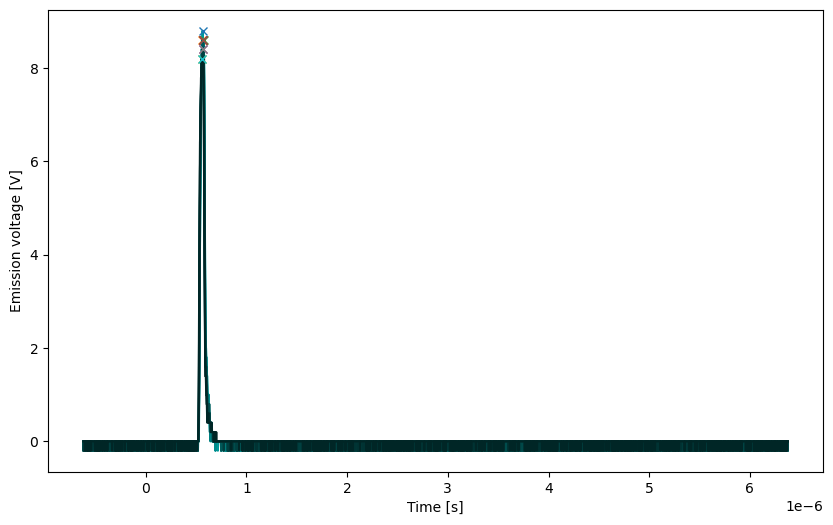

In [5]:
"""Plot of emission"""

df = pd.DataFrame({'v_field': [list(np.arange(6,0,-0.5))], 'transit_time':  [np.zeros(12)], 'transit_time_unc': [np.zeros(12)]}) # empty df

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Emission voltage [V]')

for i in range(8,18): # didn't include data for lower collecter voltage because the plots were weird 
    data = pd.read_csv(f"./data/SDS{i:05}.csv",
                  skiprows=12,
                  names = ("time", "v_field", "v_collected", "v_emitted"))
    
    # plot all data yay
    emission_plots(data)
        

C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))
C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))
C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a

,v_field,transit_time,fwhm,skewness,skewness_error
0,6.0,0.000001,9.931606e-07,2.274364e-08,3.736514e-11
1,5.5,0.000002,1.051190e-06,2.224942e-08,2.784034e-11
2,5.0,0.000002,1.115122e-06,2.121791e-08,2.297164e-11
3,4.5,0.000002,1.201041e-06,2.006652e-08,2.612516e-11
4,4.0,0.000002,1.284935e-06,1.819330e-08,2.607047e-11
5,3.5,0.000002,1.292929e-06,1.811328e-08,2.345499e-11
6,3.0,0.000002,1.388900e-06,1.604609e-08,2.655743e-11
7,2.5,0.000002,1.498769e-06,1.334617e-08,2.618583e-11
8,2.0,0.000002,1.590786e-06,1.035194e-08,2.522409e-11
9,1.5,0.000002,1.756712e-06,7.339537e-09,2.905709e-11


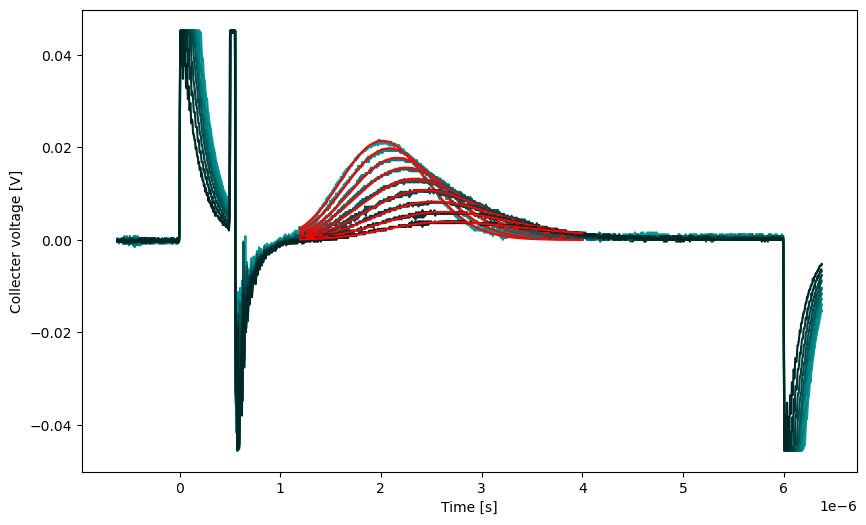

In [21]:
collector1_df = pd.DataFrame({'v_field': [np.nan]*12, 'transit_time':  [np.nan]*12,'fwhm': [np.nan]*12, 'skewness': [np.nan]*12, 'skewness_error': [np.nan]*12}) 

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Collecter voltage [V]')

for i in range(8,19): # data sets 19 and 20, clipping has occured, so these datasets have been ignored
    if (i==13):
         # data sets 12 and 13 are duplicates <-- skip dataset 13
        continue
    if (i>13):
        i-=1
    
    data = pd.read_csv(f"./data/SDS{i:05}.csv",
                  skiprows=12,
                  names = ("time", "v_field", "v_collected", "v_emitted"))
    
    # plot all data yay
    ax.plot(data['time'], data['v_collected'] , color =(0,1-i*0.05,1-i*0.05))

    t_transit, fwhm, skewness = get_transit_time(data, 1.2e-6, 4e-6)
    
    collector1_df.loc[i-8 ,'v_field'] = 6 - (i-8)*0.5 # v_field starts at 6 and counts down
    collector1_df.loc[i-8 ,'transit_time'] = t_transit
    collector1_df.loc[i-8 ,'fwhm'] = fwhm
    collector1_df.loc[i-8 ,'skewness'] = skewness[0]
    collector1_df.loc[i-8 ,'skewness_error'] = skewness[1]

collector1_df.dropna(inplace=True)    
collector1_df

Drift velocity:
$$v_d = \mu E$$

Time of transit should be a constant:
$$t = \frac{d_3 L}{\mu V}$$


Gradient: 2.0689222135727243e-05 +- 9.122803295059596e-07
Intercept: -8.026600418576791 +- 0.5230712676455674


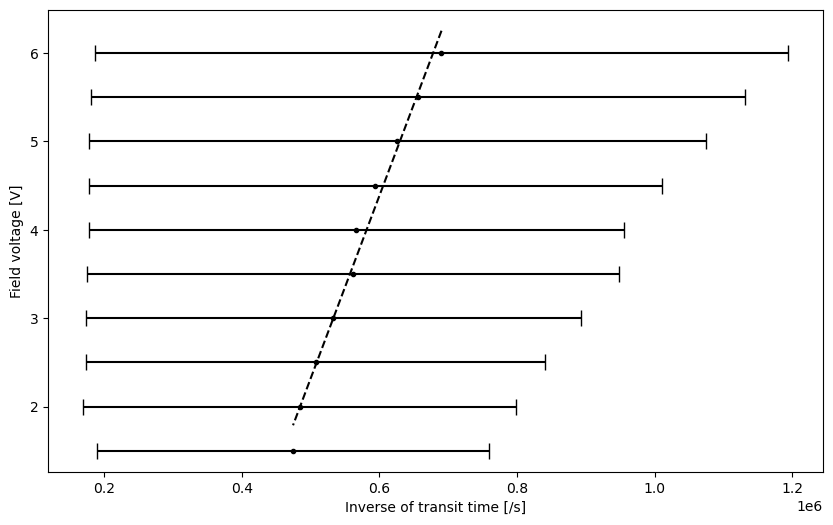

In [7]:
"""Plot of drift time against voltage"""

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Inverse of transit time [/s]')
ax.set_ylabel('Field voltage [V]')

ax.errorbar(1/collector1_df.transit_time[:10], collector1_df.v_field[:10],
            xerr= 1/collector1_df.fwhm[:10]/2, #error/2 because add half of fwhm on each
            marker='.',
            color = 'k',
            linestyle='none',
            capsize=6)

#popt,pcov curve_fit(function, x, y)
popt, pcov = curve_fit(straight_line, 1/collector1_df.transit_time[:10], collector1_df.v_field[:10])
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(f"Gradient: {slope} +- {err_slope}\nIntercept: {intercept} +- {err_intercept}")

line_fit = straight_line(1/collector1_df.transit_time[:10],slope,intercept)
ax.plot(1/collector1_df.transit_time[:10], line_fit, 'k--')

### 3b) Carrier transport



**Calculations**

Drift velocity, mobility, thermal velocity,  mean free scattering time for holes:


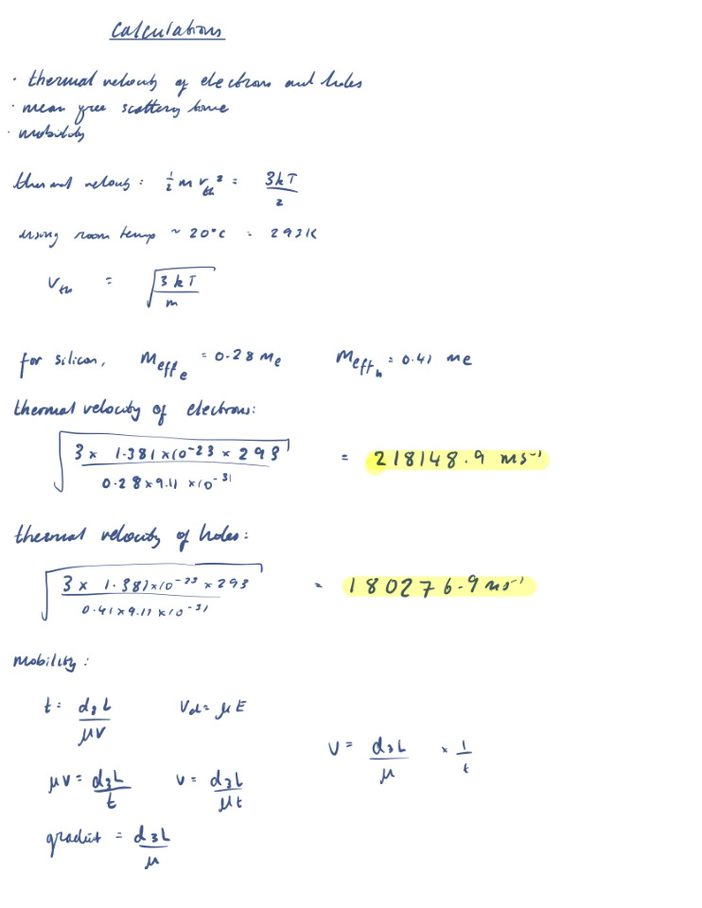
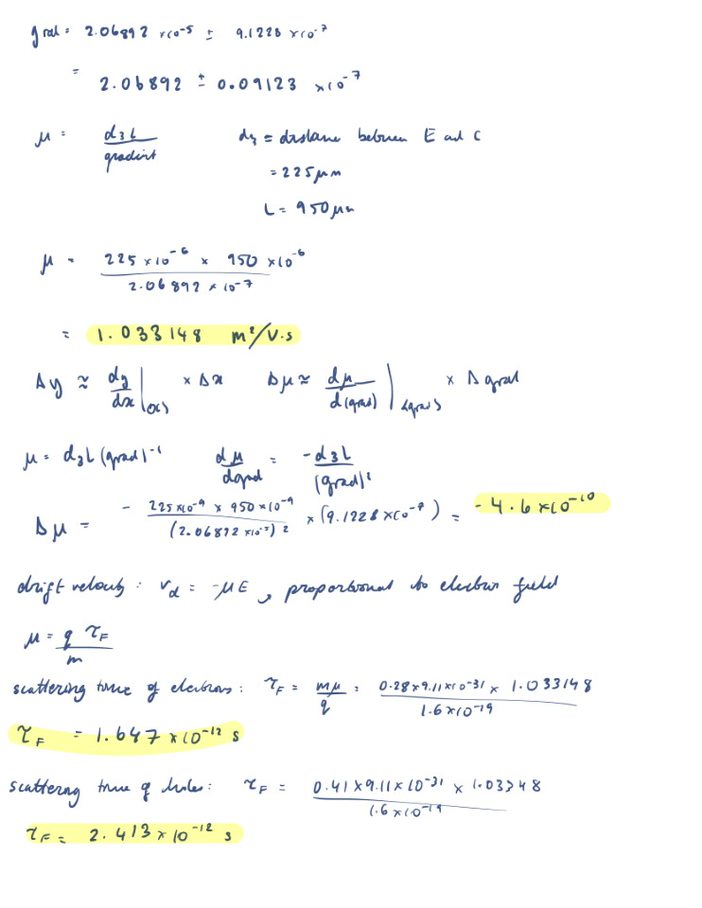

**Finding Carrier diffusion:**
- the hole pulse broadens with time due to diffusion 

To compare the widths at different times, data collected at each of the collectors needs to be compared. This involves finding the arrival times for collector 1, collector 2, collector 3 and collector 4 and measuring their widths at half maxima.

5.4e-07
5.42e-07
5.42e-07
5.44e-07


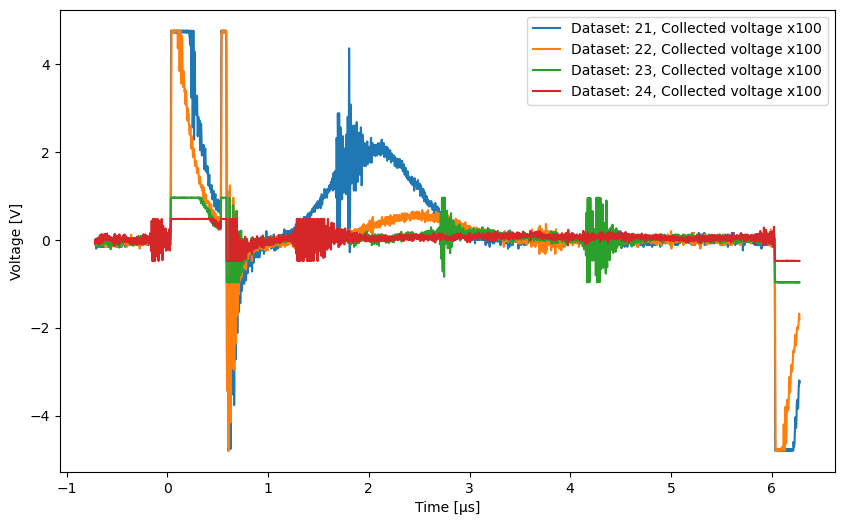

In [8]:
"""EXAMPLE: """
"""Note: these plots are using results which have not used averaging"""
# for an individual field voltage, find the time of arrival at each collector and the corresponding fwhm 

# plot data for 
fig, ax = plt.subplots(figsize=(10,6))  
for i in (21, 22, 23, 24):
    raw_data = pd.read_csv(f"./data/SDS{i:05}.csv",
                        skiprows=12,
                        names = ("time", "v_fld", "v_emit", "v_coll"))
    
    #ax.plot(raw_data["time"]/scale, raw_data["v_fld"], label= f'Field Voltage {i}', color = colour[i-21])
    ax.plot(raw_data["time"]/scale, raw_data["v_coll"]*100, label= f'Dataset: {i}, Collected voltage x100')
    #ax.plot(raw_data["time"]/scale, raw_data["v_emit"], label= f'Pulse {i}', color = colour[i-21])

    ax.set_xlabel('Time [µs]')
    ax.set_ylabel('Voltage [V]')
    ax.legend(loc = 'upper right')

    # find when the pulse was emitted
    print(raw_data['time'][raw_data['v_emit'].idxmax()])

Let's create a df for each collector:

25


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


26


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


27


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


28


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


29


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


30


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


31


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


32


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


,v_field,transit_time,fwhm,skewness,skewness_error
0,6.0,0.000002,9.972542e-07,6.233865e-09,1.324902e-11
1,5.5,0.000002,1.059181e-06,5.674893e-09,1.083158e-11
2,5.0,0.000002,1.125112e-06,4.942872e-09,9.862295e-12
3,4.5,0.000002,1.213031e-06,4.172806e-09,1.023939e-11
4,4.0,0.000002,1.247003e-06,3.286577e-09,1.128347e-11
5,3.5,0.000003,1.332938e-06,2.426465e-09,1.124784e-11
6,3.0,0.000003,1.326942e-06,1.549069e-09,1.129097e-11
7,2.5,0.000003,1.231016e-06,6.785697e-10,7.020505e-12


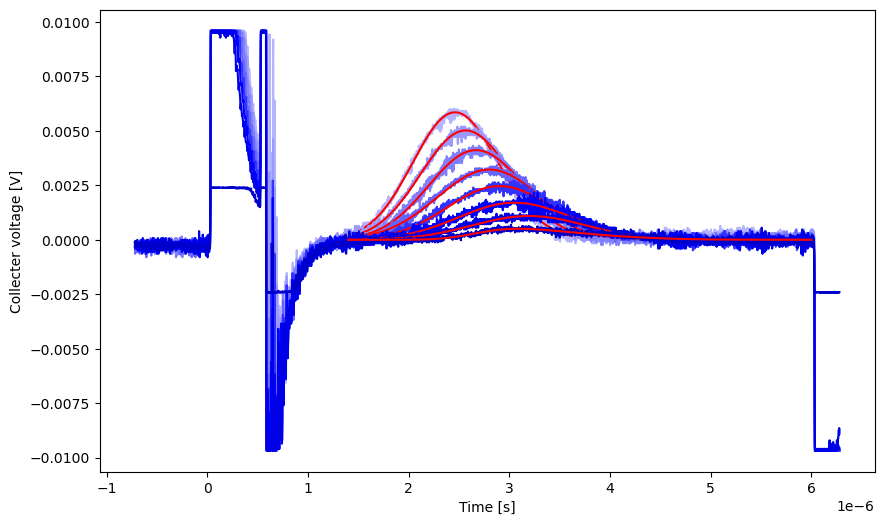

In [22]:
collector2_df = pd.DataFrame({'v_field': [np.nan]*12, 'transit_time':  [np.nan]*12,'fwhm': [np.nan]*12, 'skewness': [np.nan]*12, 'skewness_error': [np.nan]*12}) 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Collecter voltage [V]')

for i in range(25,33): # data from datasets 33, 34,35,36 is not 'curvy' enough <-- fwhm would be way too big
    print(i)
    
    data = pd.read_csv(f"./data/SDS{i:05}.csv",
                  skiprows=12,
                  names = ("time", "v_fld", "v_emitted", "v_collected"))
    
    # plot all data yay
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Collecter voltage [V]')
    
    ax.plot(data['time'], data['v_collected'] , color = colours[i-25])
   
    t_transit, fwhm, skewness = get_transit_time(data, 1.4e-6, 6e-6)
    
    collector2_df.loc[i-25 ,'v_field'] = 6 - (i-25)*0.5 # v_field starts at 6 and counts down
    collector2_df.loc[i-25 ,'transit_time'] = t_transit
    collector2_df.loc[i-25 ,'fwhm'] = fwhm
    collector2_df.loc[i-25 ,'skewness'] = skewness[0]
    collector2_df.loc[i-25 ,'skewness_error'] = skewness[1]
    

collector2_df.dropna(inplace=True)    
collector2_df

37


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


38


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


39


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


40


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


41


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


42


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


,v_field,transit_time,fwhm,skewness,skewness_error
0,6.0,0.000002,0.000001,2.052115e-09,9.926518e-12
1,5.5,0.000002,0.000001,1.837330e-09,9.214944e-12
2,5.0,0.000003,0.000001,1.356253e-09,7.464214e-12
3,4.5,0.000003,0.000001,1.006187e-09,6.382135e-12
4,4.0,0.000003,0.000001,6.173540e-10,5.316313e-12
5,3.5,0.000003,0.000001,2.281796e-10,4.565698e-12
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


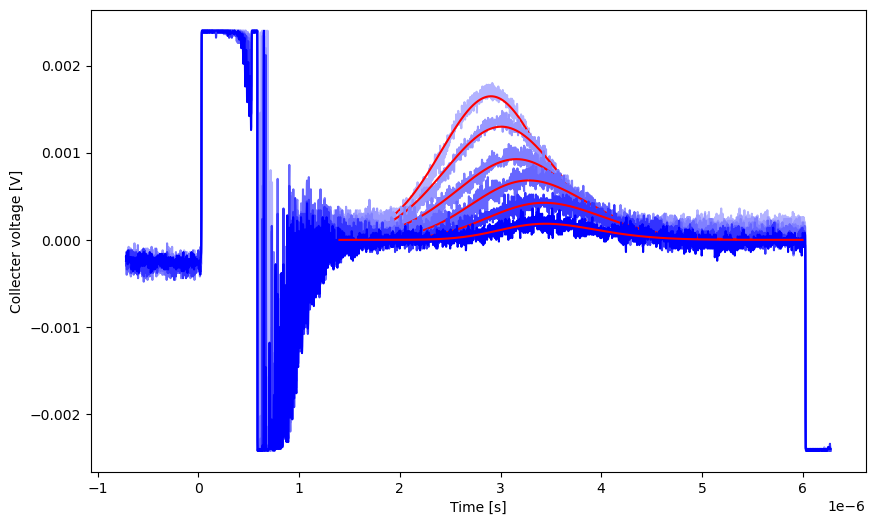

In [10]:
collector3_df = pd.DataFrame({'v_field': [np.nan]*12, 'transit_time':  [np.nan]*12,'fwhm': [np.nan]*12, 'skewness': [np.nan]*12, 'skewness_error': [np.nan]*12}) 

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Collecter voltage [V]')

for i in range(37,43): # data from datasets 33, 34,35,36 is not 'curvy' enough <-- fwhm would be way too big
    print(i)
    
    data = pd.read_csv(f"./data/SDS{i:05}.csv",
                  skiprows=12,
                  names = ("time", "v_fld", "v_emitted", "v_collected"))
    
    # plot all data yay    
    ax.plot(data['time'], data['v_collected'] , color = colours[i - 37])
    
    t_transit, fwhm, skewness = get_transit_time(data, 1.4e-6, 6e-6)
    
    collector3_df.loc[i-37 ,'v_field'] = 6 - (i-37)*0.5 # v_field starts at 6 and counts down
    collector3_df.loc[i-37 ,'transit_time'] = t_transit
    collector3_df.loc[i-37 ,'fwhm'] = fwhm
    collector3_df.loc[i-37 ,'skewness'] = skewness[0]
    collector3_df.loc[i-37 ,'skewness_error'] = skewness[1]


collector3_df.dropna(inplace=True)
collector3_df

48


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


49


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


50


C:\Users\mnjen\AppData\Local\Temp\ipykernel_2676\1904108537.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curve_df["fit_vals"] = curve_df["time"].map(lambda x: skewed_gaussian(x, *popt))


,v_field,transit_time,fwhm,skewness,skewness_error
0,6.0,0.000003,0.000001,7.125605e-10,6.059278e-12
1,5.5,0.000003,0.000002,5.580727e-10,6.185014e-12
2,5.0,0.000003,0.000001,3.265524e-10,4.739802e-12


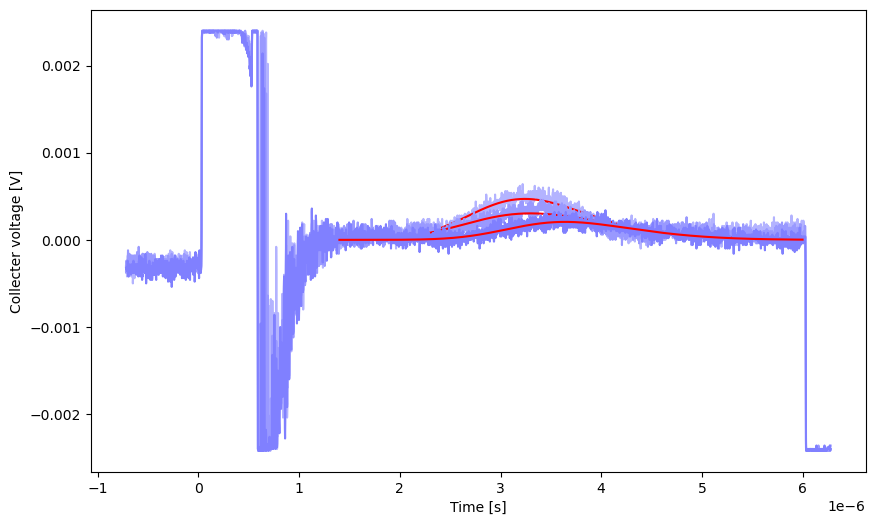

In [23]:
collector4_df = pd.DataFrame({'v_field': [np.nan]*12, 'transit_time':  [np.nan]*12,'fwhm': [np.nan]*12, 'skewness': [np.nan]*12, 'skewness_error': [np.nan]*12}) 

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Collecter voltage [V]')

for i in range(48,51): # data after dataset 51 doesn't have a noticeable 'bump'
    print(i)
    
    data = pd.read_csv(f"./data/SDS{i:05}.csv",
                  skiprows=12,
                  names = ("time", "v_fld", "v_emitted", "v_collected"))
    
    # plot all data yay
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Collecter voltage [V]')
    
    ax.plot(data['time'], data['v_collected'] , color = colours[i - 48])
    
    t_transit, fwhm, skewness = get_transit_time(data, 1.4e-6, 6e-6)
    
    collector4_df.loc[i-48 ,'v_field'] = 6 - (i-48)*0.5 # v_field starts at 6 and counts down
    collector4_df.loc[i-48 ,'transit_time'] = t_transit
    collector4_df.loc[i-48 ,'fwhm'] = fwhm
    collector4_df.loc[i-48 ,'skewness'] = skewness[0]
    collector4_df.loc[i-48 ,'skewness_error'] = skewness[1]


collector4_df.dropna(inplace=True)
collector4_df

Note how the data becomes noisier, the further the collector is from where the pulse was injected. Also note how the max height of the collected voltage decreases the further the collector is. <-- caused by diffusion

**Investigating diffusion:**

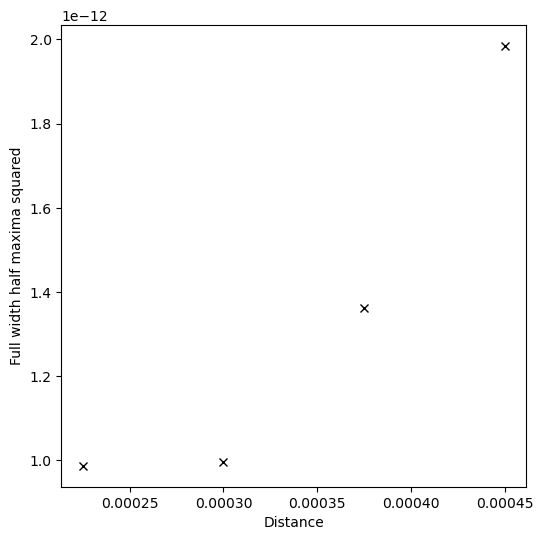

[9.931606113816638e-07,
 9.97254230374582e-07,
 1.1670715487921039e-06,
 1.4088875043806727e-06]

In [12]:
"""EXAMPLE"""
"""Using data taken when the field voltage = 6V"""
fwhm_6V = [collector1_df.fwhm[0], collector2_df.fwhm[0], collector3_df.fwhm[0], collector4_df.fwhm[0]]
distance_6V = [L1, L2, L3, L4]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Distance')
ax.set_ylabel('Full width half maxima squared')
ax.plot(distance_6V, [n**2 for n in fwhm_6V], 'kx')
plt.show()

"""Show vals of field voltage at 6V"""
fwhm_6V

Note that there are no error bars here. This is because the distance from the collector was given without error bars, and the fwhm is the error on the time of arrival of the pulse.

Gradient: 539.163661738357 +- 25.959864388497095
Intercept: 2.748746217905405e-08 +- 6.30828873095581e-08


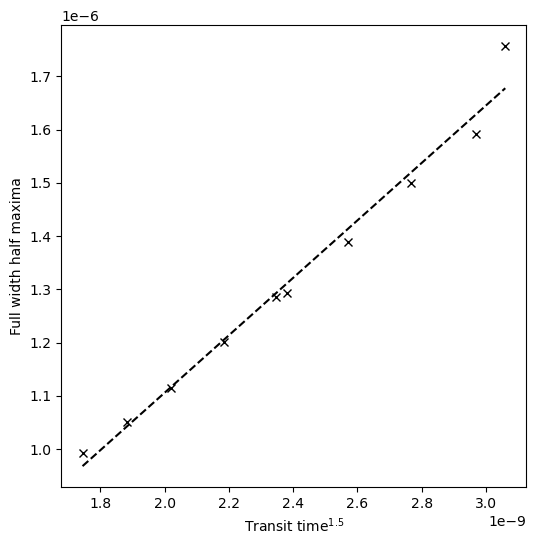

In [24]:
"""Make a plot of the fwhm against time of arrival for the first collector"""
transit_time = collector1_df.loc[:, "transit_time"] **1.5
fwhm_collector1 = collector1_df.loc[:, "fwhm"]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Transit time$^{1.5}$')
ax.set_ylabel('Full width half maxima')
ax.plot(transit_time, fwhm_collector1, 'kx') #plotting all but last value because error so high (-3 because last 2 vals in list are nans)

"""Curve fit straight line"""
popt, pcov = curve_fit(straight_line, transit_time, fwhm_collector1)
slope,intercept = popt
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(f"Gradient: {slope} +- {err_slope}\nIntercept: {intercept} +- {err_intercept}")

line_fit = straight_line(transit_time, slope,intercept)
ax.plot(transit_time, line_fit, 'k--')

plt.show()